### Import libraries

In [1]:
# import statements
%load_ext autoreload
%load_ext jupyternotify
%autoreload 2
%cd "../../"

import torch 
from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    

import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import pickle
from scipy.cluster.vq import kmeans2
import scipy.stats as ss
from scipy.io import loadmat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

/m/home/home5/56/kapoorj1/unix/repos/bayesian-ode


### Generate data

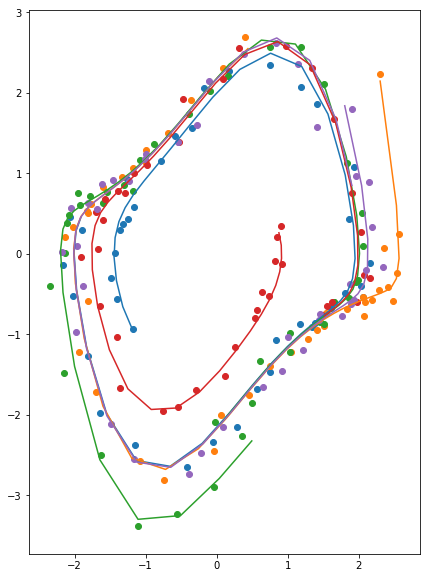

In [45]:
# generate data
use_gpu = 1

class VDP(torch.nn.Module):
    def forward(self, t, x):
        return torch.cat([x[:,1:2], 1*(1-x[:,0:1]**2)*x[:,1:2]-x[:,0:1]],1)

from torchdiffeq import odeint_adjoint as odeint
# from torchdiffeq import odeint

device = torch.device('cuda:' + str(use_gpu) if torch.cuda.is_available() else 'cpu')

N = 5
R = 3

x0 = torch.from_numpy(2*R*ss.uniform.rvs(size=[N,2])-R)
t = torch.linspace(0., 7., 40)
# t = torch.linspace(0., 21., 120)

with torch.no_grad():
    X = odeint(VDP(), x0, t, method='rk4').numpy()
    X = np.transpose(X,[1,0,2])
    Y = X + ss.norm.rvs(size=X.shape)*0.1

    
plt.figure(1,[7,10])
for i in range(X.shape[0]):
    plt.plot(X[i,:,0],X[i,:,1],'-')
    plt.scatter(Y[i,:,0],Y[i,:,1])

## Implementation-1, gradients computed via sensitivities (uses autograd as a subroutine) 

In [46]:
data = {'N': N, 'R': R, 'noise': 0.1, 'x0': x0, 't': t, 'X': X, 'Y': Y}
pickle.dump(data, open('data/vdp.pickle', 'wb'))

### Initialize the model, parameters, variables, etc

In [164]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def _flatten(sequence):
    flat = [p.contiguous().view(-1) for p in sequence]
    return torch.cat(flat) if len(flat) > 0 else torch.tensor([])

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_) # not whitened
Linv = torch.cholesky(K(Zt,Zt)).inverse()
U0 = torch.mm(Linv,U0) # whitened

class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.Z = Zt
        self.Kzz = K(Zt,Zt)
        self.Kzzinv = self.Kzz.inverse()
        self.L = torch.cholesky(self.Kzz)
        self.KzzinvL = torch.mm(self.Kzzinv,self.L)

    def forward(self, t, X):
        T = torch.mm(K(X,self.Z),self.KzzinvL)
        return torch.mm(T,self.U)

class ODEINT_FS(torch.autograd.Function):
    @staticmethod
    def forward(ctx, func, x0, t, th):
        xode = odeint(func, x0, t, method='rk4').permute([1,0,2])
        ctx.func = func
        ctx.save_for_backward(x0,t,th,xode)
        return xode # N,T,D
    @staticmethod
    def backward(ctx, *grad_output): # grad_output[0] N,T,D ---> dL/dxode
        # print('backward')
        func = ctx.func
        x0,t,th,xode = ctx.saved_tensors
        N = x0.shape[0]  # problem dimensionality
        D = x0.shape[1]  # problem dimensionality
        MD = torch.numel(th) # number of parameters in the differential function
        with torch.no_grad():
            def ode_sens_rhs(t,xS): # xS = N,D,(1+MD)
                x = xS[:,:,0].view(-1,D) # N,D
                S = xS[:,:,1:] # N,D,MD
                th = list(func.parameters())[0]
                dxs = []
                dSs = []
                for j in range(N):
                    x_ = x[j:j+1].requires_grad_(True) #.detach() # 1,D
                    S_ = S[j] # D,MD
                    J = [] # accumulate columns of J here
                    R = [] # accumulate columns of R here
                    for i in range(D): # partial derivative of output dimension i 
                        with torch.set_grad_enabled(True):
                            f = func(t,x_)[0,i]
                            dfdxth = torch.autograd.grad(f, [x_,th], allow_unused=False, retain_graph=False)
                            J.append(dfdxth[0])
                            R.append(dfdxth[1].view(1,-1)) # 1,MD
                    J = torch.cat(J) # D,D
                    R = torch.cat(R) # D,MD
                    dS = torch.matmul(J,S_)+R # D,MD
                    dx = func(t,x_) # 1,D
                    dxs.append(dx.unsqueeze(2)) # 1,D,1
                    dSs.append(dS.unsqueeze(0)) # 1,D,MD
                dx = torch.cat(dxs) # N,D,1
                dS = torch.cat(dSs) # N,D,MD
                dxdS = torch.cat([dx,dS],2)
                return dxdS
            x0 = torch.unsqueeze(x0,2) # N,D,1
            S0 = torch.zeros(N,D,MD)
            xS0 = torch.cat((x0,S0),2) # N,D,(1+MD)
            xS = odeint(ode_sens_rhs, xS0, t, method='rk4') # T,N,D,(1+MD)
            xode2 = xS[:,:,:,0].permute([1,0,2]) # N,T,D
            # print('error between two ode integrations is {:f}'.format(torch.abs(xode-xode2).sum().numpy()))
            S = xS[:,:,:,1:].permute([1,2,0,3]) # N,D,T,MD
            # print(grad_output[0].shape) # N,T,D
            dlossdx = grad_output[0].permute([0,2,1]).unsqueeze(3) # N,D,T,1
            dlossdU = torch.sum(S*dlossdx,[0,1,2]) # MD
        return None,None,None,dlossdU # N,T,D
    
odeint_fs = ODEINT_FS.apply
kreg = KernelRegression()

# check why doesn't work
# from torch.autograd import gradcheck
# th_ = _flatten(kreg.parameters())
# test = gradcheck(odeint_fs, [kreg,x0,t,th_], eps=1e-6, atol=1e-4)
# print(test)

def odeint_forw_sens(func, x0, t):
    th = _flatten(func.parameters())
    xode = odeint_fs(kreg, x0, t, th)
    return xode
    

### Optimize

In [165]:
# optimization

logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
params = [kreg.U,logsn]
optimizer = optim.Adam(params, lr=5e-3)

    
for itr in range(500):
    optimizer.zero_grad()
    T   = min(3+itr//10, len(t))
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint_forw_sens(kreg,x0,t_)
    loss = torch.sum((Yt_-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt_)*torch.sum(logsn)/D + \
        torch.sum(torch.diag(torch.mm(kreg.U.t(),kreg.U)))/2
    loss.backward()
    optimizer.step()

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint_forw_sens(kreg,x0,t)
            loss = torch.sum((Yt-xode)**2 / torch.exp(logsn)**2) +  torch.numel(Yt)*torch.sum(logsn)/D
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    # break
    end = time.time()


ValueError: func is required to be an instance of nn.Module.

### Visualize

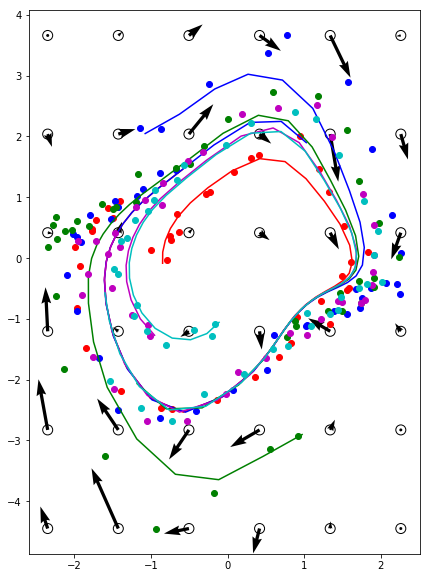

In [135]:
# plotting
xode = odeint_forw_sens(kreg, x0, t).detach().numpy()
U = kreg.U.detach().numpy()
Z = Zt.detach().numpy()

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(Y[i,:,0],Y[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

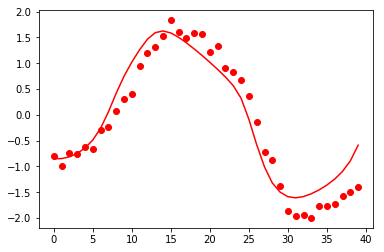

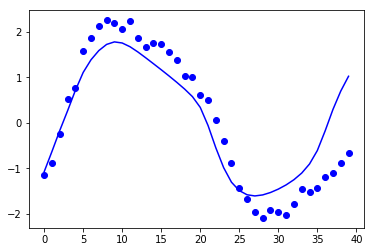

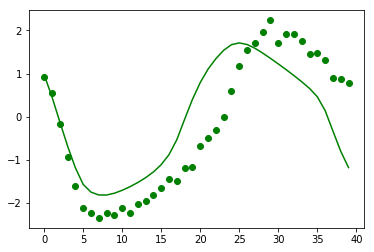

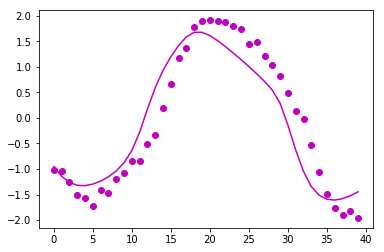

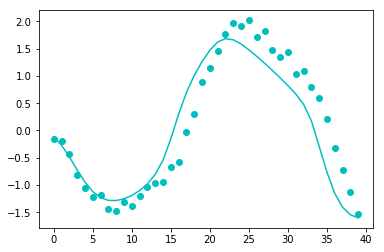

In [136]:
for i in range(min(6,xode.shape[0])):
    fig, ax = plt.subplots()
    ax.plot(Y[i,:,0],'o',color=cols[i])
    ax.plot(xode[i,:,0],'-',color=cols[i])

## Implementation-2 that uses Torch autograd, no sensitivities/adjoints 

### Initialize the model, parameters, variables, etc

In [166]:
# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Xt[:,1:,:]-Xt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Xt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)
    

Kzzinv = K(Zt, Zt).inverse()

npode = KernelRegression()
# lbfgs = optim.LBFGS(npode.parameters(), lr=1e-3)
optimizer = optim.Adam(npode.parameters(), lr=5e-3)
# optimizer = optim.SGD(npode.parameters(), lr=3e-5)


### Optimize

In [167]:
# optimization
def closure():
    optimizer.zero_grad()
    xode = odeint(npode, x0, t).permute([1,0,2])
    loss = torch.mean((Xt-xode)**2 / torch.exp(npode.logsn))
    loss.backward()
    return loss

    
# n_iters = 1000
n_iters = 1000

## learning rate scheduling for sgd+momentum and rmsprop
lr = 5e-4
lr_decay=0.03

## Momentum schedulin for sgd+momentum
mom_init = 0.5
mom_final = 0.99
mom_decay = 0.03

for itr in range(n_iters):
    optimizer.zero_grad()

#     for g in optimizer.param_groups:
#         g['lr'] = lr/(1+lr_decay*i)
#     for g in optimizer.param_groups:
#         g['momentum'] = mom_final - (mom_final-mom_init)/(1+mom_decay*i)

    xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
    loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn)**2) +  torch.numel(Xt)*torch.sum(npode.logsn)/D + \
        torch.sum(torch.diag(torch.mm(npode.U.t(), torch.mm(Kzzinv, npode.U))))/2
    loss.backward()
    optimizer.step()
#     lbfgs.step(closure)

    if itr % 1 == 0:
        with torch.no_grad():
            xode = odeint(npode, x0, t, method='rk4').permute([1,0,2])
            if torch.isnan(loss):
                %notify -m "Nan encountered in loss"
                break
            loss = torch.sum((Xt-xode)**2 / torch.exp(npode.logsn))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))

    end = time.time()

Iter 0000 | Total Loss 87.553523
Iter 0001 | Total Loss 77.711588
Iter 0002 | Total Loss 68.431103
Iter 0003 | Total Loss 59.777767
Iter 0004 | Total Loss 51.814059
Iter 0005 | Total Loss 44.596556
Iter 0006 | Total Loss 38.172763
Iter 0007 | Total Loss 32.577992
Iter 0008 | Total Loss 27.832609
Iter 0009 | Total Loss 23.939709
Iter 0010 | Total Loss 20.883210
Iter 0011 | Total Loss 18.625894
Iter 0012 | Total Loss 17.107282
Iter 0013 | Total Loss 16.242399
Iter 0014 | Total Loss 15.922735
Iter 0015 | Total Loss 16.019994
Iter 0016 | Total Loss 16.392590
Iter 0017 | Total Loss 16.894700
Iter 0018 | Total Loss 17.387455
Iter 0019 | Total Loss 17.751217
Iter 0020 | Total Loss 17.897016
Iter 0021 | Total Loss 17.774579
Iter 0022 | Total Loss 17.374856
Iter 0023 | Total Loss 16.726492
Iter 0024 | Total Loss 15.887346
Iter 0025 | Total Loss 14.933205
Iter 0026 | Total Loss 13.945865
Iter 0027 | Total Loss 13.002279
Iter 0028 | Total Loss 12.165857
Iter 0029 | Total Loss 11.480537
Iter 0030 

Iter 0255 | Total Loss 5.461546
Iter 0256 | Total Loss 5.450878
Iter 0257 | Total Loss 5.440298
Iter 0258 | Total Loss 5.429803
Iter 0259 | Total Loss 5.419394
Iter 0260 | Total Loss 5.409069
Iter 0261 | Total Loss 5.398827
Iter 0262 | Total Loss 5.388667
Iter 0263 | Total Loss 5.378587
Iter 0264 | Total Loss 5.368588
Iter 0265 | Total Loss 5.358666
Iter 0266 | Total Loss 5.348821
Iter 0267 | Total Loss 5.339051
Iter 0268 | Total Loss 5.329354
Iter 0269 | Total Loss 5.319730
Iter 0270 | Total Loss 5.310175
Iter 0271 | Total Loss 5.300689
Iter 0272 | Total Loss 5.291270
Iter 0273 | Total Loss 5.281915
Iter 0274 | Total Loss 5.272622
Iter 0275 | Total Loss 5.263391
Iter 0276 | Total Loss 5.254217
Iter 0277 | Total Loss 5.245100
Iter 0278 | Total Loss 5.236037
Iter 0279 | Total Loss 5.227027
Iter 0280 | Total Loss 5.218065
Iter 0281 | Total Loss 5.209151
Iter 0282 | Total Loss 5.200282
Iter 0283 | Total Loss 5.191455
Iter 0284 | Total Loss 5.182668
Iter 0285 | Total Loss 5.173919
Iter 028

KeyboardInterrupt: 

### Visualize

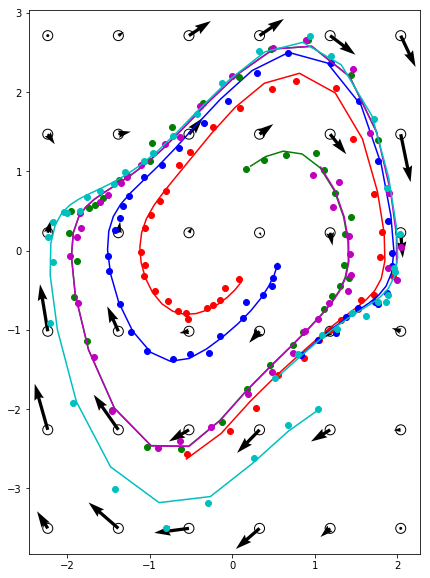

In [192]:
# plotting
xode = odeint(npode, x0, t).detach().numpy()
U = npode.U.detach().numpy()
Z = npode.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    plt.plot(Y[i,:,0],Y[i,:,1],'o',color=cols[i])
    plt.plot(xode[i,:,0],xode[i,:,1],'-',color=cols[i])

In [259]:
torch.exp(npode.logsn)

tensor([0.1035, 0.1168], grad_fn=<ExpBackward>)

## Inference using MCMC

In [4]:

# create variables, functions etc
M   = 6 # MxM inducing grid
D   = 2
sf  = 1
ell = 0.75
# ell = 1

torch.set_default_tensor_type(torch.DoubleTensor)
xv = np.linspace(np.min([np.min(Y_[:,0]) for Y_ in Y]), np.max([np.max(Y_[:,0]) for Y_ in Y]), M)
yv = np.linspace(np.min([np.min(Y_[:,1]) for Y_ in Y]), np.max([np.max(Y_[:,1]) for Y_ in Y]), M)
xv,yv = np.meshgrid(xv,yv)
Z  = np.array([xv.T.flatten(),yv.T.flatten()]).T
Zt = torch.from_numpy(Z)
Xt = torch.from_numpy(X)
Yt = torch.from_numpy(Y)
U0 = 0.1*torch.randn(M*M, D)
# U0 = VDP().forward(0,Zt)

def sq_dist(X1,X2):
    X1 = X1 / ell
    X1s = torch.sum(X1**2, dim=1).view([-1,1]) 
    X2 = X2 / ell
    X2s = torch.sum(X2**2, dim=1).view([1,-1])
    return -2*torch.mm(X1,torch.t(X2)) + X1s + X2s

def K(X1,X2):
    dist = sq_dist(X1,X2)
    return sf**2 * torch.exp(-dist / 2)

# gradient matching
F_ = (Yt[:,1:,:]-Yt[:,:-1,:]) / (t[1]-t[0])
F_ = F_.contiguous().view(-1,D)
Z_ = Yt[:,:-1,:].contiguous().view(-1,D)
Kxz = K(Zt,Z_)
Kzzinv = (K(Z_,Z_)+0.2*torch.eye(Z_.shape[0])).inverse()
U0 = torch.mm(torch.mm(Kxz,Kzzinv),F_)


class KernelRegression(torch.nn.Module):
    def __init__(self):
        super(KernelRegression, self).__init__()
        self.U = torch.nn.Parameter(U0, requires_grad=True)
        self.logsn = torch.nn.Parameter(torch.zeros(2)+np.log(0.05), requires_grad=True)
        self.Z = Zt

    def forward(self, t, X):
#         Z = self.Z
#         M = Z.shape[0]
#         N = X.shape[0]
#         A_LU = torch.lu(K(Z,Z).view(-1,M,M)) # 1,M,M
#         Kxz  = torch.t(K(X,Z)).view(-1,M,N)  # 1,M,N
#         A = torch.lu_solve(Kxz, *A_LU).view(M,N) # M x N
#         f = torch.mm(torch.t(A),self.U) # N x M
#         return f|
#         Z = self.Z
#         Ltinv = torch.t(torch.cholesky(K(Z,Z))).inverse()
#         return torch.mm(torch.mm(K(X,Z),Ltinv),self.U)
        Z = self.Z
        Kzzinv = K(Z,Z).inverse()
        return torch.mm(torch.mm(K(X,Z),Kzzinv),self.U)

kreg = KernelRegression()
Kzzinv = K(Zt, Zt).inverse()
# lbfgs = optim.LBFGS(npode.parameters(), lr=5e-3)
# optimizer = optim.Adam(npode.parameters(), lr=5e-3)

### Inference

itr = 0


def closure(add_prior=True):
    global itr
#     T   = min(3+itr//10, len(t))
    T   = len(t)
    itr += 1
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = None  
    if add_prior:
        loss = torch.sum((Yt_-xode)**2/(2*torch.exp(kreg.logsn)**2))
        loss += torch.numel(Yt_)*torch.sum(kreg.logsn)/D
        loss += torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    else:
        loss = torch.sum((Yt_-xode)**2)
    return loss

def psgld_closure(add_prior=True):
    global itr
#     T   = min(3+itr//10, len(t))
    T   = len(t)
    itr += 1
    t_  = t[:T]
    Yt_ = Yt[:,:T,:]
    xode = odeint(kreg, x0, t_, method='rk4').permute([1,0,2])
    loss = None  
    if add_prior:
        loss = torch.sum((Yt_-xode)**2/(2*torch.exp(kreg.logsn)**2))
        loss += torch.numel(Yt_)*torch.sum(kreg.logsn)/D
        loss += torch.sum(torch.diag(torch.mm(kreg.U.t(),torch.mm(Kzzinv, kreg.U))))/2
    else:
        loss = torch.sum((Yt_-xode)**2)
    return loss/N


# logsn = torch.nn.Parameter(torch.zeros(2), requires_grad=True)
# logsn = torch.log(torch.Tensor([0.1]))
# params = kreg.parameters()
params = [kreg.U, kreg.logsn]

from samplers.langevin import MALA, MMALA, pSGLD, HAMCMC, HAMCMC2, HAMCMC3, HAMCMC4
from samplers.hamiltonian import aSGHMC

# sampler = MMALA(params, metric_obj=metric, lr=1e-4)
# sampler = MALA(params, lr=1e-4, add_noise=True)
# sampler = SGLD(params, lr0=0.0001, gamma=0.55, t0=100, alpha=0.1)


# chain, logp_array = sampler.sample(closure, burn_in=2000, num_samples=1000, print_loss=True)

# sampler = pSGLD(params, lr0=3e-2, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, lambda_=1e-8, alpha=0.99)
# chain, logp_array = sampler.sample(psgld_closure, burn_in=600, num_samples=1000, print_loss=True)

# sampler = HAMCMC(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-5, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_metric=True)

# sampler = HAMCMC2(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-3, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_old_lbfgs=True, add_noise=False)

# sampler = HAMCMC3(params, lr0=1e-4, lr_gamma=0.55, lr_t0=100, lr_alpha=0.3, trust_reg=1e0, memory=3, H_gamma=1e-3, cholesky_factor=1e-3)
# chain, logp_array = sampler.sample(closure, burn_in=500, num_samples=100, print_loss=True, use_old_lbfgs=True, add_noise=False)

itr = 0
lr=1e-2
def lr_scheduler():
    global itr
    itr += 1
#     if itr >500:
#         return lr/np.sqrt((1+0.1*itr))
    return lr

sampler = aSGHMC(params, lr=lr, add_noise=True)
chain, logp_array = sampler.sample(closure, burn_in=600, num_samples=1000, print_loss=True, lr_scheduler=lr_scheduler)


<class 'dict'>
Burn-in phase started
Burn-in iter 0001 | loss 83.791696
Burn-in iter 0002 | loss 83.341667
Burn-in iter 0003 | loss 82.723009
Burn-in iter 0004 | loss 81.955223
Burn-in iter 0005 | loss 81.057693
Burn-in iter 0006 | loss 80.043973
Burn-in iter 0007 | loss 78.926706
Burn-in iter 0008 | loss 77.719979
Burn-in iter 0009 | loss 76.436293
Burn-in iter 0010 | loss 75.084912
Burn-in iter 0011 | loss 73.673843
Burn-in iter 0012 | loss 72.212394
Burn-in iter 0013 | loss 70.706644
Burn-in iter 0014 | loss 69.162463
Burn-in iter 0015 | loss 67.584228
Burn-in iter 0016 | loss 65.980038
Burn-in iter 0017 | loss 64.357124
Burn-in iter 0018 | loss 62.721709
Burn-in iter 0019 | loss 61.079930
Burn-in iter 0020 | loss 59.438920
Burn-in iter 0021 | loss 57.801600
Burn-in iter 0022 | loss 56.172774
Burn-in iter 0023 | loss 54.557312
Burn-in iter 0024 | loss 52.963586
Burn-in iter 0025 | loss 51.396917
Burn-in iter 0026 | loss 49.861608
Burn-in iter 0027 | loss 48.364722
Burn-in iter 0028 

Burn-in iter 0238 | loss 4.347583
Burn-in iter 0239 | loss 4.338554
Burn-in iter 0240 | loss 4.328396
Burn-in iter 0241 | loss 4.310367
Burn-in iter 0242 | loss 4.286569
Burn-in iter 0243 | loss 4.263541
Burn-in iter 0244 | loss 4.248922
Burn-in iter 0245 | loss 4.240840
Burn-in iter 0246 | loss 4.238901
Burn-in iter 0247 | loss 4.242132
Burn-in iter 0248 | loss 4.239192
Burn-in iter 0249 | loss 4.226626
Burn-in iter 0250 | loss 4.204257
Burn-in iter 0251 | loss 4.182377
Burn-in iter 0252 | loss 4.158404
Burn-in iter 0253 | loss 4.131866
Burn-in iter 0254 | loss 4.109527
Burn-in iter 0255 | loss 4.092130
Burn-in iter 0256 | loss 4.077642
Burn-in iter 0257 | loss 4.064640
Burn-in iter 0258 | loss 4.059362
Burn-in iter 0259 | loss 4.057014
Burn-in iter 0260 | loss 4.053484
Burn-in iter 0261 | loss 4.042588
Burn-in iter 0262 | loss 4.024131
Burn-in iter 0263 | loss 4.006611
Burn-in iter 0264 | loss 3.989328
Burn-in iter 0265 | loss 3.972957
Burn-in iter 0266 | loss 3.961529
Burn-in iter 0

Burn-in iter 0479 | loss 2.799840
Burn-in iter 0480 | loss 2.791406
Burn-in iter 0481 | loss 2.788526
Burn-in iter 0482 | loss 2.784527
Burn-in iter 0483 | loss 2.781202
Burn-in iter 0484 | loss 2.775736
Burn-in iter 0485 | loss 2.769762
Burn-in iter 0486 | loss 2.765631
Burn-in iter 0487 | loss 2.761166
Burn-in iter 0488 | loss 2.759720
Burn-in iter 0489 | loss 2.761303
Burn-in iter 0490 | loss 2.765800
Burn-in iter 0491 | loss 2.767665
Burn-in iter 0492 | loss 2.763179
Burn-in iter 0493 | loss 2.755333
Burn-in iter 0494 | loss 2.750977
Burn-in iter 0495 | loss 2.736999
Burn-in iter 0496 | loss 2.729978
Burn-in iter 0497 | loss 2.724037
Burn-in iter 0498 | loss 2.725035
Burn-in iter 0499 | loss 2.729124
Burn-in iter 0500 | loss 2.730740
Burn-in iter 0501 | loss 2.736744
Burn-in iter 0502 | loss 2.748788
Burn-in iter 0503 | loss 2.765904
Burn-in iter 0504 | loss 2.777300
Burn-in iter 0505 | loss 2.784234
Burn-in iter 0506 | loss 2.782683
Burn-in iter 0507 | loss 2.785176
Burn-in iter 0

Sample iter 0123 | loss 2.174021
Sample iter 0124 | loss 2.171294
Sample iter 0125 | loss 2.166838
Sample iter 0126 | loss 2.160189
Sample iter 0127 | loss 2.144903
Sample iter 0128 | loss 2.134977
Sample iter 0129 | loss 2.119241
Sample iter 0130 | loss 2.100396
Sample iter 0131 | loss 2.086731
Sample iter 0132 | loss 2.078067
Sample iter 0133 | loss 2.073635
Sample iter 0134 | loss 2.072174
Sample iter 0135 | loss 2.070071
Sample iter 0136 | loss 2.068390
Sample iter 0137 | loss 2.065002
Sample iter 0138 | loss 2.057263
Sample iter 0139 | loss 2.050907
Sample iter 0140 | loss 2.044077
Sample iter 0141 | loss 2.041716
Sample iter 0142 | loss 2.041396
Sample iter 0143 | loss 2.042985
Sample iter 0144 | loss 2.042898
Sample iter 0145 | loss 2.036353
Sample iter 0146 | loss 2.026409
Sample iter 0147 | loss 2.014639
Sample iter 0148 | loss 2.006867
Sample iter 0149 | loss 1.995451
Sample iter 0150 | loss 1.984505
Sample iter 0151 | loss 1.975744
Sample iter 0152 | loss 1.971500
Sample ite

Sample iter 0372 | loss 1.689879
Sample iter 0373 | loss 1.692650
Sample iter 0374 | loss 1.703152
Sample iter 0375 | loss 1.711273
Sample iter 0376 | loss 1.708141
Sample iter 0377 | loss 1.700979
Sample iter 0378 | loss 1.696468
Sample iter 0379 | loss 1.694757
Sample iter 0380 | loss 1.691063
Sample iter 0381 | loss 1.684226
Sample iter 0382 | loss 1.676860
Sample iter 0383 | loss 1.671540
Sample iter 0384 | loss 1.665823
Sample iter 0385 | loss 1.660815
Sample iter 0386 | loss 1.656637
Sample iter 0387 | loss 1.660423
Sample iter 0388 | loss 1.668670
Sample iter 0389 | loss 1.668832
Sample iter 0390 | loss 1.660690
Sample iter 0391 | loss 1.651107
Sample iter 0392 | loss 1.650158
Sample iter 0393 | loss 1.657151
Sample iter 0394 | loss 1.664711
Sample iter 0395 | loss 1.659685
Sample iter 0396 | loss 1.648886
Sample iter 0397 | loss 1.640735
Sample iter 0398 | loss 1.643596
Sample iter 0399 | loss 1.654874
Sample iter 0400 | loss 1.665803
Sample iter 0401 | loss 1.668971
Sample ite

Sample iter 0621 | loss 1.508275
Sample iter 0622 | loss 1.489978
Sample iter 0623 | loss 1.487753
Sample iter 0624 | loss 1.504959
Sample iter 0625 | loss 1.526058
Sample iter 0626 | loss 1.535645
Sample iter 0627 | loss 1.530279
Sample iter 0628 | loss 1.522327
Sample iter 0629 | loss 1.525464
Sample iter 0630 | loss 1.535627
Sample iter 0631 | loss 1.532801
Sample iter 0632 | loss 1.513323
Sample iter 0633 | loss 1.497823
Sample iter 0634 | loss 1.505266
Sample iter 0635 | loss 1.520823
Sample iter 0636 | loss 1.526352
Sample iter 0637 | loss 1.515382
Sample iter 0638 | loss 1.511468
Sample iter 0639 | loss 1.522897
Sample iter 0640 | loss 1.537959
Sample iter 0641 | loss 1.536457
Sample iter 0642 | loss 1.523282
Sample iter 0643 | loss 1.515343
Sample iter 0644 | loss 1.523857
Sample iter 0645 | loss 1.533731
Sample iter 0646 | loss 1.538348
Sample iter 0647 | loss 1.533062
Sample iter 0648 | loss 1.522857
Sample iter 0649 | loss 1.520507
Sample iter 0650 | loss 1.524616
Sample ite

Sample iter 0870 | loss 1.531351
Sample iter 0871 | loss 1.528464
Sample iter 0872 | loss 1.530155
Sample iter 0873 | loss 1.525709
Sample iter 0874 | loss 1.519158
Sample iter 0875 | loss 1.520352
Sample iter 0876 | loss 1.526935
Sample iter 0877 | loss 1.533052
Sample iter 0878 | loss 1.535380
Sample iter 0879 | loss 1.527773
Sample iter 0880 | loss 1.519597
Sample iter 0881 | loss 1.518781
Sample iter 0882 | loss 1.526641
Sample iter 0883 | loss 1.531192
Sample iter 0884 | loss 1.531642
Sample iter 0885 | loss 1.530685
Sample iter 0886 | loss 1.531307
Sample iter 0887 | loss 1.538830
Sample iter 0888 | loss 1.552246
Sample iter 0889 | loss 1.556755
Sample iter 0890 | loss 1.560587
Sample iter 0891 | loss 1.559356
Sample iter 0892 | loss 1.557322
Sample iter 0893 | loss 1.556811
Sample iter 0894 | loss 1.551347
Sample iter 0895 | loss 1.545979
Sample iter 0896 | loss 1.543291
Sample iter 0897 | loss 1.547692
Sample iter 0898 | loss 1.552824
Sample iter 0899 | loss 1.554679
Sample ite

### Visualization

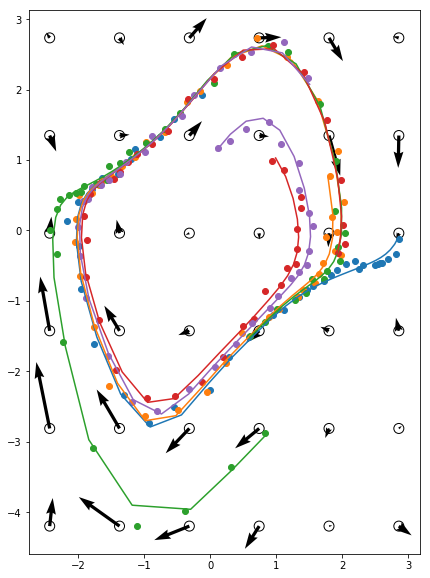

In [25]:
chain = sampler.samples[-400::10]
# plotting
mean_U = np.mean([i[0][0][0] for i in chain if i[1]], axis=0)

kreg.U.data = torch.from_numpy(mean_U)
mean_logsn = np.mean([i[0][0][1] for i in chain if i[1]], axis=0)
kreg.logsn.data = torch.from_numpy(mean_logsn)
xode = odeint(kreg, x0, t).detach().numpy()
# U = kreg.U.detach().numpy()
U = mean_U
Z = kreg.Z.detach().numpy()
xode = np.transpose(xode,[1,0,2])

cols = ['r','b','g','m','c','k']
plt.figure(1,[7,10])
plt.scatter(Z[:,0],Z[:,1],100, facecolors='none', edgecolors='k')
plt.quiver(Z[:,0],Z[:,1],U[:,0],U[:,1],units='height',width=0.006,color='k')
for i in range(min(6,xode.shape[0])):
    color=np.random.rand(3)
    plt.scatter(Y[i,:,0],Y[i,:,1],)
    plt.plot(xode[i,:,0],xode[i,:,1],'-')

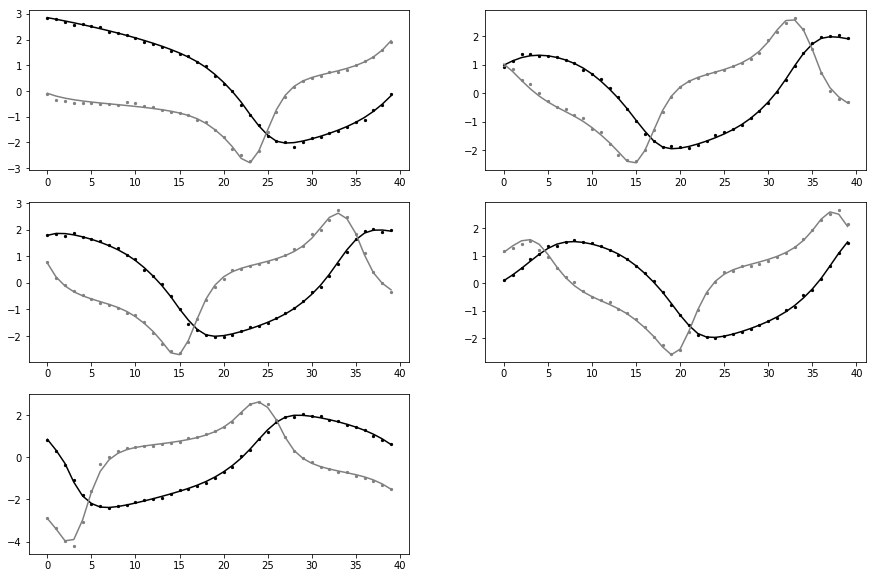

In [26]:
fig, ax = plt.subplots(nrows=(min(6,xode.shape[0])+1)//2, ncols=2, figsize=(15,10))
axes = [ax[i][j] for j in range(2) for i in range(len(ax))]
for i in range(min(6,xode.shape[0])):
    axes[i].scatter(range(len(Y[i,:,0])),Y[i,:,0],color='k',s=5)
    axes[i].plot(xode[i,:,0],'-',color='k')
    axes[i].scatter(range(len(Y[i,:,1])),Y[i,:,1],color='gray',s=5)
    axes[i].plot(xode[i,:,1],'-',color='gray')
for i in range(min(6,xode.shape[0]), len(axes)):
    fig.delaxes(axes[i])

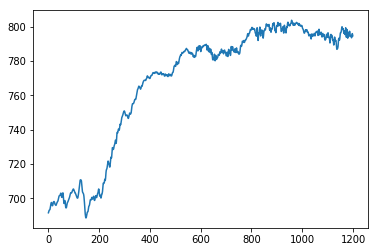

In [27]:
plt.plot(logp_array[400:])

In [23]:
R_= 2
x0_ = torch.from_numpy(2*R_*ss.uniform.rvs(size=[10,2])-R_)
t_ = torch.linspace(0., 28., 160)
t_numpy = t_.clone().detach().numpy()

xode_gp = []
for i in range(len(chain)):
    kreg.U.data = torch.from_numpy(chain[i][0][0][0])
    xode_gp.append(odeint(kreg, x0_, t_).detach().numpy())
    xode_gp[-1] = np.transpose(xode_gp[-1],[1,0,2])

xode_gp_mean = np.zeros_like(xode_gp[0])
xode_gp_std = np.zeros_like(xode_gp[0])

for i in range(xode_gp_mean.shape[0]):
    xode_gp_mean[i,:,0] = np.mean([xode_gp[j][i,:,0] for j in range(len(xode_gp))], axis=0)
    xode_gp_mean[i,:,1] = np.mean([xode_gp[j][i,:,1] for j in range(len(xode_gp))], axis=0)
    xode_gp_std[i,:,0] = np.std([xode_gp[j][i,:,0] for j in range(len(xode_gp))], axis=0)
    xode_gp_std[i,:,1] = np.std([xode_gp[j][i,:,1] for j in range(len(xode_gp))], axis=0)
    
    
xode_real = odeint(VDP(), x0_, t_).detach().numpy()
xode_real = np.transpose(xode_real,[1,0,2])

    

(10, 160, 2)
(10, 160, 2)
(10, 160, 2)


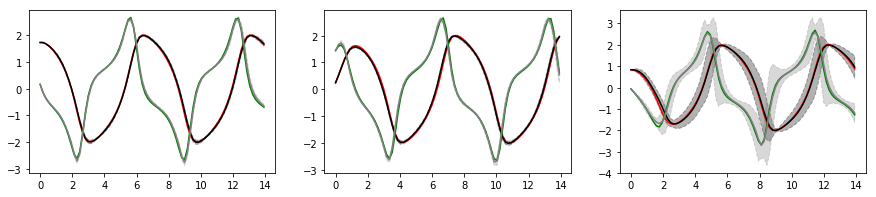

In [39]:
print(xode_gp_mean.shape)
print(xode_gp_std.shape)
print(xode_real.shape)


num_plots = 3
# fig, ax = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15,10))
fig, axes = plt.subplots(ncols=num_plots, nrows=1, figsize=(15,3))
# axes = [ax[i][j] for j in range(2) for i in range(len(ax))]
for i in range(num_plots):
    axes[i].plot(t_numpy[:80],xode_real[i,0:80,0],'-',color='r')
    axes[i].fill_between(x=t_numpy[:80],
                         y1=xode_gp_mean[i,0:80,0]-5*xode_gp_std[i,0:80,0],
                         y2=xode_gp_mean[i,0:80,0]+5*xode_gp_std[i,0:80,0],
                         linestyle='--',color='k', alpha=0.3)
    axes[i].plot(t_numpy[:80],
                 xode_gp_mean[i,0:80,0],
                 linestyle='-',color='k')
    axes[i].plot(t_numpy[:80],xode_real[i,0:80,1],'-',color='g')
    axes[i].fill_between(x=t_numpy[:80],
                         y1=xode_gp_mean[i,0:80,1]-5*xode_gp_std[i,0:80,1],
                         y2=xode_gp_mean[i,0:80,1]+5*xode_gp_std[i,0:80,1],
                         linestyle='--',color='gray', alpha=0.3)
    axes[i].plot(t_numpy[:80],
                 xode_gp_mean[i,0:80,1],
                 linestyle='-',color='gray')
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

[-2.9774654 -2.3216651]


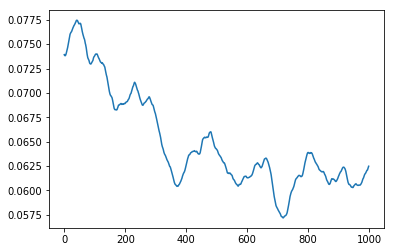

In [40]:
plt.plot([np.mean(np.exp(i[0][0][1])) for i in sampler.samples[:] if i[1]])
print(sampler.samples[10][0][0][1])
